In [1]:
from torch import nn
import torch, gym, gym_unbalanced_disk, time, gym.wrappers
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import os
from matplotlib import pyplot as plt

In [2]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [3]:
def show(Q,env,setting):
    u = []
    theta = []
    omega = []
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                if setting == "u":
                    print(env.u)
                elif setting == 'omega':
                    print(env.omega)
                elif setting == 'theta':
                    print(env.th)
                u.append(env.u)
                theta.append(env.th)
                omega.append(env.omega)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()
            return u,theta,omega
        

def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, done, info = env.step(action) #d)
            rewards_acc += reward #d)
            if done: #d)
                return rewards_acc #d)

In [4]:
max_episode_steps = 300
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

Folder


In [5]:
env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)
# env.set_discrete_values_manual([-3.0, -1.5, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1.5, 3.0])

Discrete value set changed to [-3.0, -1.2, -0.48, -0.19, 0, 0.19, 0.48, 1.2, 3.0]


In [6]:
# # Load the .npy file with allow_pickle=True
# Q = np.load('Qfunction.npz')

# Create an instance of Qfunction
Q = Qfunction(env)

# Load Q from the saved file
Q.load_state_dict(torch.load('QfunctionYann.pt'))

<All keys matched successfully>

In [7]:
u,theta,omega = show(Q,env,'theta')

pygame 2.4.0 (SDL 2.26.4, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html
0.024879634237671887
0.09403727539669772
0.20140004416429153
0.3373999687568643
0.4908434730890696
0.6501705728605857
0.80468466346877
0.9454778109921762
1.065881545771409
1.161452189925012
1.2296406203690535
1.2693407984007041
1.2805423774249238
1.2685595526379694
1.2371621028757074
1.187771555739087
1.11368721310075
1.009561945247938
0.8804249170853321
0.715776708007784
0.5087740289261442
0.2741379876767329
0.029735368556410235
-0.2052782916961955
-0.41294530830333587
-0.5613761176012992
-0.616392490016508
-0.5724066045464337
-0.43942685321218844
-0.2295951632899089
0.038995512228069545
0.3435862590091496
0.6598087660478651
0.9657691543866882
1.245376779823887
1.4895684194466392
1.695480544291192
1.86457606353486
2.000723442696096
2.108738856738702
2.19347659503057
2.2593537171977562
2.310157273609811
2.3490117002471593
2.3784253399484325
2.400368337665589
2.41635623066459

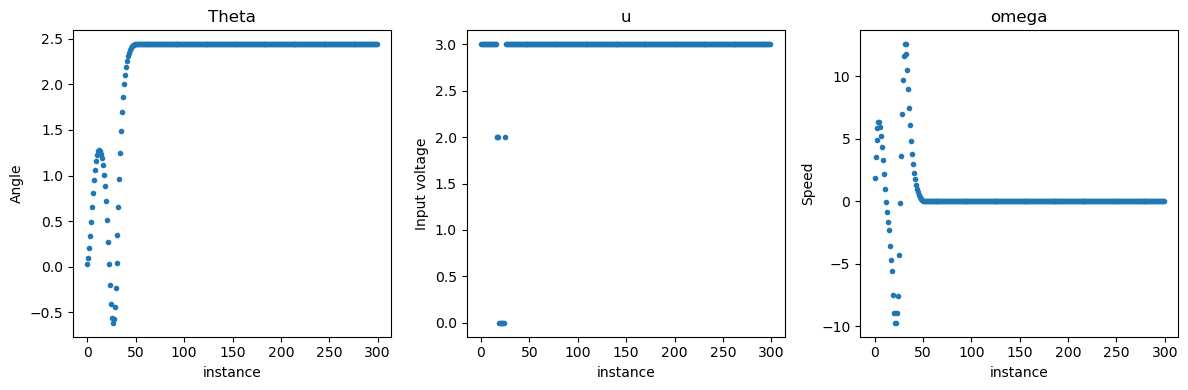

In [8]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot theta
axs[0].plot(theta, '.')
axs[0].set_title('Theta')
axs[0].set_xlabel('instance')
axs[0].set_ylabel('Angle')

# Plot u
axs[1].plot(u, '.')
axs[1].set_title('u')
axs[1].set_xlabel('instance')
axs[1].set_ylabel('Input voltage')

# Plot omega
axs[2].plot(omega, '.')
axs[2].set_title('omega')
axs[2].set_xlabel('instance')
axs[2].set_ylabel('Speed')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
eval_Q(Q,env)

80.75294057213534

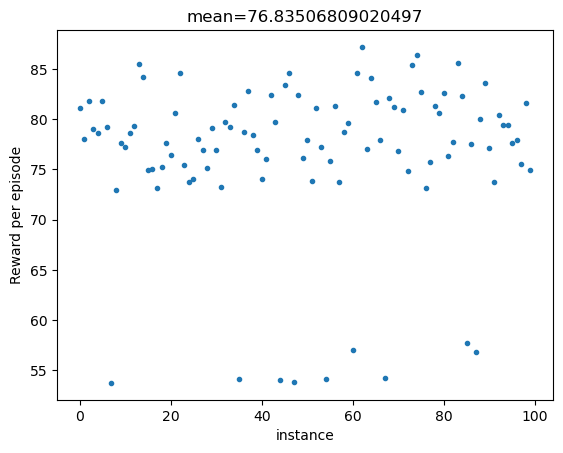

In [10]:
Rewards = [eval_Q(Q,env) for i in range(100)]
plt.plot(Rewards,'.')
plt.title(f'mean={np.mean(Rewards)}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.show()

In [11]:
def argmax(a):
    #argmax([0,1,2,3]) -> 3
    #argmax([0,1,2,2]) -> 2 or 3 with equal probability of both (np.argmax would only return 2)
    #argmax([0,0,0,0]) -> 0, 1, 2 or 3 with equal probability of each (np.argmax would only return 0)
    a = np.array(a)
    return np.random.choice(np.arange(a.shape[0],dtype=int)[a==np.max(a)])

In [12]:
def make_radial_basis_network(env,nvec,scale):
    # env: is the given enviroment
    # nvec: is the given number of grid points in each dimention.
    # scale: is the sigma_c in the equation
    if isinstance(nvec,int):
        nvec = [nvec]*env.observation_space.shape[0]
    
    # This creates a grid of points c_i the lower bound to the upper bound with nvec number of samples in each dimention
    low, high = env.observation_space.low, env.observation_space.high # get upper and lower bound
    assert np.all(np.isfinite(low)) and np.all(np.isfinite(high)), f'infinite bounds on obersvation space are not permitted low={low}, high={high}'
    Xvec = [np.linspace(l,h,num=ni) for l,h,ni in zip(low,high,nvec)] # calculate the linspace in all directions
    c_points = np.array(np.meshgrid(*Xvec)) # meshgrid all the linspaces together (Nx, X1, X2, X3, ...) 
    c_points = np.moveaxis(c_points, 0, -1) #transform to (X1, X2, X3, ..., Nobs) 
    c_points = c_points.reshape((-1,c_points.shape[-1])) #flatten into the size (Nc, Nobs)
    dx = np.array([X[1]-X[0] for X in Xvec]) # spacing (related to the B matrix)
    
    def basis_fun(obs):
        #this function should return the vector containing all phi_i of all c_points
        obs = np.array(obs) #(Nobs)
        
        dis = (c_points-obs[None,:])/dx[None,:] #dim = (Nbasis, Nobs)
        exp_arg = np.sum(dis**2,axis=1)/(2*scale**2) #squared distance to every point #b)
        Z = -exp_arg+np.min(exp_arg) #b) for numerical stability you can add the minimum.
        R = np.exp(Z) #b)
        return R/np.sum(R) #b)
    
    return basis_fun #returns a basis function

In [13]:
def visualize_theta(env, theta, basis_fun):
    # for a given enviroment, theta matrix (Nbasis, Naction) and basis_fun(obs) -> (Nbasis,) 
    # it visualizes the max Q value in state-space.
    low, high = env.observation_space.low, env.observation_space.high
    nvec = [50,60]
    Xvec = [np.linspace(l,h,num=ni) for l,h,ni in zip(low,high,nvec)] # calculate the linspace in all directions
    c_points = np.array(np.meshgrid(*Xvec)) # meshgrid all the linspaces together (Nx, X1, X2, X3, ...) 
    c_points = np.moveaxis(c_points, 0, -1) #transform to (X1, X2, X3, ..., Nobs) 
    c_points = c_points.reshape((-1,c_points.shape[-1])) #flatten into the size (Nc, Nobs)
    maxtheta = np.array([np.max(basis_fun(ci)@theta) for ci in c_points]).reshape((nvec[1],nvec[0]))
    
    plt.contour(Xvec[0],Xvec[1],maxtheta)
    plt.xlabel('position')
    plt.ylabel('velocity')
    plt.colorbar()
    plt.show()

In [14]:
def roll_mean(ar,start=400,N=25):
    s = 1-1/N
    k = start
    out = np.zeros(ar.shape)
    for i,a in enumerate(ar):
        k = s*k + (1-s)*a
        out[i] = k
    return out

In [15]:
nvec = 10
scale = 0.5
basis_fun = make_radial_basis_network(env,nvec,scale=scale) #e)

In [16]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))
    
def show(Q,env,setting):
    u = []
    theta = []
    omega = []
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                if setting == "u":
                    print(env.u)
                elif setting == 'omega':
                    print(env.omega)
                elif setting == 'theta':
                    print(env.th)
                u.append(env.u)
                theta.append(env.th)
                omega.append(env.omega)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()
            return u,theta,omega
        
def rollout(Q, env, epsilon=0.1, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    # Qfun( a numpy array of the obs) -> a numpy array of Q values
    Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() 
    with torch.no_grad():
        
        obs = env.reset() #c)
        for i in range(N_rollout): #c)
            if np.random.uniform()>epsilon: #c)
                Qnow = Qfun(obs) #c)
                action = np.argmax(Qnow) #c)
            else: #c)
                action = env.action_space.sample() #c)
            Start_state.append(obs) #c)
            Actions.append(action) #c)

            obs_next, reward, done, info = env.step(action) #c)
            terminal = done and not info.get('TimeLimit.truncated', False) #c)

            Terminal.append(terminal) #c)
            Rewards.append(reward) #c)
            End_state.append(obs_next) #c)

            if done: #c)
                obs = env.reset() #c)
            else: #c)
                obs = obs_next #c)
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Dones)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, done, info = env.step(action) #d)
            rewards_acc += reward #d)
            if done: #d)
                return rewards_acc #d)
            
def DQN_rollout(Q, optimizer, env, gamma=0.98, use_target_net=False, N_iterations=21, N_rollout=20000, \
                N_epochs=10, batch_size=32, N_evals=10, target_net_update_feq=100):
    best = -float('inf')
    torch.save(Q.state_dict(),'Q-checkpoint')
    ep_length = []
    scores = []
    try:
        for iteration in range(N_iterations):
            epsilon = 1.0 - iteration/(N_iterations-1) #e=) 1.
            print(f'rollout iteration {iteration} with epsilon={epsilon:.2%}...')
            
            #2. rollout
            Start_state, Actions, Rewards, End_state, Dones = rollout(Q, env, epsilon=epsilon, N_rollout=N_rollout) #e) 2.
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Dones = convert([Start_state, Rewards, End_state, Dones])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            t = 0
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    if t%target_net_update_feq==0:
                        Qtarget = deepcopy(Q) #g)
                        pass
                    t += 1
                    
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Dones_batch = [d[i-batch_size:i] for d in [Start_state, Actions, Rewards, End_state, Dones]] #e=) 3.
                    
                    with torch.no_grad(): #3.
                        if use_target_net:
                            maxQ = torch.max(Qtarget(End_state_batch),dim=1)[0] #g)
                        else:
                            maxQ = torch.max(Q(End_state_batch),dim=1)[0] #e=) 3.
                    
                    action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0)
                    Qnow = Q(Start_state_batch)[action_index] #Q(x_t,u_t) is given
                    
                    Loss = torch.mean((Rewards_batch + gamma*maxQ*(1-Dones_batch) - Qnow)**2) #e) 3.
                    optimizer.zero_grad() #e) 3.
                    Loss.backward() #e) 3.
                    optimizer.step() #e) 3.
                
                score = np.mean([eval_Q(Q,env) for i in range(N_evals)]) #e=) 3.

                scores.append(score)
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving Q... \n#################################')
                    torch.save(Q.state_dict(),'Q-checkpoint')
            
            print('loading best result')
            Q.load_state_dict(torch.load('Q-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        Q.load_state_dict(torch.load('Q-checkpoint'))
        return scores

In [17]:
max_episode_steps = 100
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

target_angle = np.pi # target set to be balanced on top


reward_function = lambda self: ((np.cos(self.th-target_angle)+1.6)** 2 - 0.25) - 0.0025*(self.omega)** 2 - 0.0075*(self.u)**2

env.change_reward_function(reward_function)

# env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)
env.set_discrete_values_manual([-3.0, -1.5, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1.5, 3.0])


gamma = 0.98 #f=)
batch_size = 32 #f=)
N_iterations = 25 #f=)
N_rollout = 5000 #f=)
N_epochs = 3 #f=)
N_evals = 3 #f=)
lr = 0.0005 #given

assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
Q = Qfunction(env)
optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
scores = DQN_rollout(Q, optimizer, env, use_target_net=False, gamma=gamma, N_iterations=N_iterations, \
            N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)

Folder
Discrete value set changed to [-3.0, -1.5, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1.5, 3.0]
rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: 44.55154482603831
################################# 
 new best 44.55154482603831 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: 42.99002496702664
iteration=0 epoch=2 Average Reward per episode: 40.122851873717515
loading best result
rollout iteration 1 with epsilon=95.83%...
starting training on rollout information...
iteration=1 epoch=0 Average Reward per episode: 46.581376314872756
################################# 
 new best 46.581376314872756 saving Q... 
#################################
iteration=1 epoch=1 Average Reward per episode: 46.58154081055556
################################# 
 new best 46.58154081055556 saving Q... 
#################################
iteration=1 epoch=2 Average Reward per episode

In [18]:
scores

[44.55154482603831,
 42.99002496702664,
 40.122851873717515,
 46.581376314872756,
 46.58154081055556,
 46.58149069644784,
 46.5808641195951,
 46.58104254325584,
 46.58119540759268,
 46.58128276515402,
 46.58120392446019,
 46.581173332126326,
 46.58134134517562,
 46.581328947905405,
 46.58112480127627,
 46.58116814605973,
 46.58113975917584,
 46.581028847233114,
 46.58147989925478,
 46.581426361306455,
 46.58124948177787,
 46.58108278566082,
 46.58134894540816,
 46.58118006304536,
 46.58140902411864,
 46.581037676462586,
 46.58085933314359,
 46.58118477322726,
 46.58115395099778,
 46.58101535439519,
 46.58119469335539,
 46.58185929851776,
 46.581101001809515,
 46.581232134180475,
 46.58090433592836,
 46.58130941968622,
 46.581210357890605,
 46.58188851993359,
 46.58120902126296,
 46.58118842361796,
 46.58118780542005,
 46.58149851307291,
 46.58133492162519,
 46.58117628796973,
 46.58103397229896,
 46.5811149650799,
 46.581313462317404,
 46.5813548880522,
 46.581309721811095,
 46.5818743

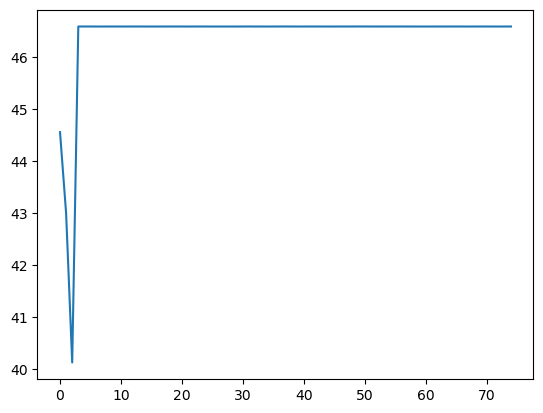

In [19]:
plt.plot(scores)

In [20]:
len(range(0,12500,50))

250

ValueError: x and y must have same first dimension, but have shapes (250,) and (75,)

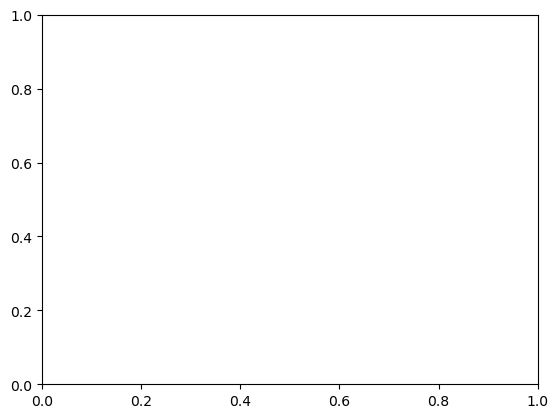

In [21]:
basis_fun = make_radial_basis_network(env,nvec=nvec,scale=scale)#d=)
plt.plot(range(0,12500,50), scores, label=f'alpha={0.5}')#d)

plt.title(f'scale={scale}')#d)
plt.legend()#d)
plt.show()#d)

In [ ]:
u,theta,omega = show(Q,env,'theta')

In [ ]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot theta
axs[0].plot(theta, '.')
axs[0].set_title('Theta')
axs[0].set_xlabel('instance')
axs[0].set_ylabel('Angle')

# Plot u
axs[1].plot(u, '.')
axs[1].set_title('u')
axs[1].set_xlabel('instance')
axs[1].set_ylabel('Input voltage')

# Plot omega
axs[2].plot(omega, '.')
axs[2].set_title('omega')
axs[2].set_xlabel('instance')
axs[2].set_ylabel('Speed')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def make_radial_basis_network(env,nvec,scale):
    # env: is the given enviroment
    # nvec: is the given number of grid points in each dimention.
    # scale: is the sigma_c in the equation
    if isinstance(nvec,int):
        nvec = [nvec]*env.observation_space.shape[0]
    
    # This creates a grid of points c_i the lower bound to the upper bound with nvec number of samples in each dimention
    low, high = env.observation_space.low, env.observation_space.high # get upper and lower bound
    assert np.all(np.isfinite(low)) and np.all(np.isfinite(high)), f'infinite bounds on obersvation space are not permitted low={low}, high={high}'
    Xvec = [np.linspace(l,h,num=ni) for l,h,ni in zip(low,high,nvec)] # calculate the linspace in all directions
    c_points = np.array(np.meshgrid(*Xvec)) # meshgrid all the linspaces together (Nx, X1, X2, X3, ...) 
    c_points = np.moveaxis(c_points, 0, -1) #transform to (X1, X2, X3, ..., Nobs) 
    c_points = c_points.reshape((-1,c_points.shape[-1])) #flatten into the size (Nc, Nobs)
    dx = np.array([X[1]-X[0] for X in Xvec]) # spacing (related to the B matrix)
    
    def basis_fun(obs):
        #this function should return the vector containing all phi_i of all c_points
        obs = np.array(obs) #(Nobs)

        print("c_points",len(c_points),c_points)
        print("obs",len(obs), obs)
        print("dx",len(dx), dx)
        print(c_points.shape)
        print(obs.shape)
        print(dx.shape)
        print()
        print(obs[None,:])
        print(c_points-obs[None,:])
        dis = (c_points-obs[None,:])/dx[None,:] #dim = (Nbasis, Nobs)
        exp_arg = np.sum(dis**2,axis=1)/(2*scale**2) #squared distance to every point #b)
        Z = -exp_arg+np.min(exp_arg) #b) for numerical stability you can add the minimum.
        R = np.exp(Z) #b)
        return R/np.sum(R) #b)
    
    return basis_fun #returns a basis function

In [ ]:
basis_fun = make_radial_basis_network(env,nvec=nvec,scale=scale)#d=)
# env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)

In [ ]:
visualize_theta(env, theta, basis_fun) #d)